# Image Classification
Classifing images from CIFAR-10 dataset using CNN. It consists of airplanes, dogs, cats, and other objects.

## Exploring the Data
The dataset is broken into 5 batches to prevent machine from running out of memory.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 19:
Image - Min Value: 9 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


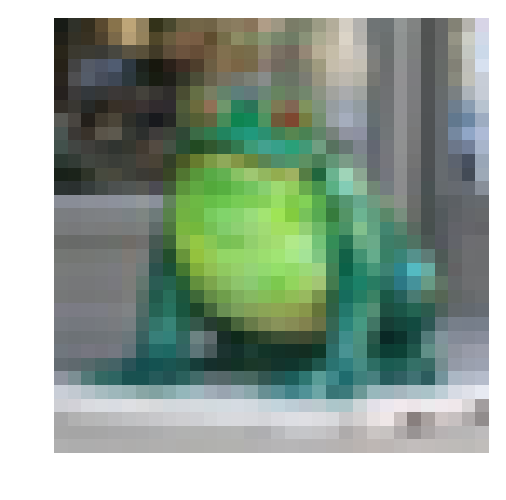

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

batch_id = 1
sample_id = 19
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

### Normalizing input images into a range of 0 to 1

In [3]:
def normalize(x):
    x_min=np.min(x)
    x_max=np.max(x)
    return (x-x_min)/(x_max-x_min)

### Encoding the labels

In [4]:
def one_hot_encode(x):
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(n_values=10)    
    one_hot_encoded_labels = enc.fit_transform(np.array(x).reshape(-1, 1)).toarray()
    return one_hot_encoded_labels

## Preprocessing and Splitting the data

In [5]:
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [6]:
import pickle
import helper

# Loading Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Building the network

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    # Tensor for image input
    # image_shape = input image details
    return tf.placeholder(tf.float32,shape=((None,)+image_shape),name='x') 
    

def neural_net_label_input(n_classes):
    # Tensor for label input
    # n_classes = number of target classes
    return tf.placeholder(tf.float32,shape=(None,+n_classes),name='y')


def neural_net_keep_prob_input():
    # Tensor for Dropout
    # keep_prob = dropout probability
    return tf.placeholder(tf.float32,shape=(None),name='keep_prob')

### Convolution and Max Pooling Layer

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):

    weights_shape=list(conv_ksize)+[x_tensor.get_shape().as_list()[3],conv_num_outputs]
    weights=tf.Variable(tf.truncated_normal(weights_shape,stddev=5e-2))
    bias=tf.Variable(tf.zeros(conv_num_outputs))
    
    #Convolution layer
    output=tf.nn.conv2d(x_tensor,weights,strides=[1,conv_strides[0],conv_strides[1],1],padding='SAME')
    output=tf.nn.bias_add(output,bias)
    output=tf.nn.relu(output)
    
    #Pooling layer
    # Implemented max pooling with padding around the input image and stride is 1
    output=tf.nn.max_pool(output,ksize=[1,pool_ksize[0],pool_ksize[1],1],
                          strides=[1,pool_strides[0],pool_strides[1],1],
                          padding='SAME')
    return output 

### Flattening Layer
Function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor (Batch Size, Flattened Image Size).

In [9]:
def flatten(x_tensor):
    tensor_shape=x_tensor.get_shape().as_list()
    #length of the flattened dimensions
    flattened_shape=np.array(tensor_shape[1:]).prod()
    flattenoutput=tf.reshape(x_tensor,[tf.shape(x_tensor)[0],flattened_shape])
    return flattenoutput

### Fully Connected Layer

In [10]:
def fully_conn(x_tensor, num_outputs):

    flattened_shape=np.array(x_tensor.get_shape().as_list()[1:]).prod()
    weights=tf.Variable(tf.truncated_normal([flattened_shape,num_outputs],stddev=0.04))
    bias=tf.Variable(tf.zeros([num_outputs]))
    
    fc=tf.nn.relu(tf.add(tf.matmul(x_tensor,weights),bias))
    return fc

### Output Layer

In [11]:
def output(x_tensor, num_outputs):

    flattened_shape=np.array(x_tensor.get_shape().as_list()[1:]).prod()
    weights=tf.Variable(tf.truncated_normal([flattened_shape,num_outputs],stddev=0.04))
    bias=tf.Variable(tf.zeros([num_outputs]))  

    outputlayer=tf.add(tf.matmul(x_tensor,weights),bias)    
    return outputlayer

### Convolutional Neural Network Model

In [12]:
def conv_net(x, keep_prob):
    conv = conv2d_maxpool(x,conv_num_outputs=128,conv_ksize=[5,5],conv_strides=[1,1],pool_ksize=[3,3],pool_strides=[2,2])
    conv = conv2d_maxpool(conv,conv_num_outputs=64,conv_ksize=[5,5],conv_strides=[1,1],pool_ksize=[3,3],pool_strides=[2,2])
    conv = conv2d_maxpool(conv,conv_num_outputs=64,conv_ksize=[3,3],conv_strides=[1,1],pool_ksize=[3,3],pool_strides=[2,2])

    #   Flatten layer
    flattened_conv=flatten(conv)
    

    # Fully Connected Layer
    fc=fully_conn(flattened_conv,384)
    
    # Dropout
    fc=tf.nn.dropout(fc,keep_prob)    
    
    # Fully Connected Layer
    fc=fully_conn(fc,192)

    return output(fc,10)


## Building the Network

tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# logits Tensor, so that this can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss function and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Training the Neural Network
### Optimization

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):

    session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob: keep_probability})

### Printing Loss and Validation accuracy.  
Not using Dropout regularization during validation and test data. Hence keep_prob is kept 1

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    
    loss=sess.run(cost,feed_dict={x: feature_batch, y: label_batch, keep_prob: 1})
    valid_acc=sess.run(accuracy,feed_dict={x: valid_features, y: valid_labels, keep_prob: 1})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))

### Hyperparameters

In [15]:
epochs = 25
batch_size = 256
keep_probability = 0.5

### Training the Model

In [16]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Saving Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1211 Validation Accuracy: 0.279400
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.7335 Validation Accuracy: 0.329800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.4883 Validation Accuracy: 0.389600
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5138 Validation Accuracy: 0.397600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.4797 Validation Accuracy: 0.468200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.5629 Validation Accuracy: 0.489000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.3243 Validation Accuracy: 0.436400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.0170 Validation Accuracy: 0.525800
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.1428 Validation Accuracy: 0.519600
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.2342 Validation Accuracy: 0.541000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.2275 Validation Accuracy: 0.548800
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.0156 Validation Accuracy: 0.566000
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.8210 Validation Accuracy: 0.541200


Epoch 22, CIFAR-10 Batch 3:  Loss:     0.0485 Validation Accuracy: 0.727200
Epoch 22, CIFAR-10 Batch 4:  Loss:     0.0538 Validation Accuracy: 0.743600
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.0330 Validation Accuracy: 0.734400
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.0898 Validation Accuracy: 0.738200
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.0591 Validation Accuracy: 0.718600
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.0428 Validation Accuracy: 0.727400
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.0785 Validation Accuracy: 0.728400
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.0380 Validation Accuracy: 0.741400
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.1262 Validation Accuracy: 0.735200
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.0363 Validation Accuracy: 0.750200
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.0423 Validation Accuracy: 0.742000
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.0506 Validation Accuracy: 0.741400
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.0515 Validation Accuracy: 0.740400
Epoch 25, CI